In [1]:
import numpy as np
import tqdm

import librosa
import librosa.core
import matplotlib.pyplot as plt
import librosa.display

import os
from glob import glob

import mir_eval

In [2]:
DATA_DIR = '/Users/sripathisridhar/Desktop/Audio'
ANNO_DIR = '/Users/sripathisridhar/Desktop/Annotations'

In [3]:
data_paths = sorted(glob(os.path.join(DATA_DIR, '*/*.wav')))
anno_paths = sorted(glob(os.path.join(ANNO_DIR, '*/*.lab')))

In [4]:
def simplify_anno(annotations):
    '''
    This function takes an annotation vector and returns a simplified version
    All chords which are not major or minor are labeled None
    Arguments:
        annotations- annotation vector
    Returns:
        anno_simple- annotation vector with 'maj', 'min', 'N' labels
    '''
    
    ban_list = ['aug', 'sus', '7', '9', '6', 'dim', 'hdim', 'majmin', '*']
    anno_simple = annotations
    
    for i, annotation in enumerate(annotations):
        if any(x in annotation for x in ban_list): # no extended chords
            anno_simple[i] = 'N'
            
        elif annotation!='N':
            if '/' in annotation: # make label inversion agnostic
                anno_simple[i], _ = annotation.split(sep='/')
                
            if ':' not in anno_simple[i]: # make 'maj' label explicit
                anno_simple[i] = anno_simple[i] + ':maj'
        
    return anno_simple

In [5]:
def log_spectrogram(y, sr=44100, nfft=8192, hop_length=4410):
    '''
    This function returns a log compressed mel-spectrogram
    Default parameters set per [Korzeniowski and Widmer, 2016]
    ----
    Arguments:
        y- time series data
        sr- sample rate
        nfft- number of samples in FFT window
        hop_length- sample distance between consecutive frames
    ----
    Returns:
        log_spectrogram- log scaled mel spectrogram
    '''
    mel_spectrogram = librosa.feature.melspectrogram(y, sr, n_fft=nfft, hop_length=hop_length)
    log_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
    
    return log_spectrogram

In [6]:
def pre_process(file_paths, context=15, nfft=8192, hop_length=4410):
    
    features_list = []
    for file_path in file_paths:
        
        # Compute log spectrogram
        y, sr = librosa.load(file_path, sr=None)
        spectrogram = log_spectrogram(y, sr)
        
        _, width = spectrogram.shape
        print(spectrogram.shape)
        features_list.append(spectrogram[:, :-np.mod(width, context)])
        
#     print(len(features_list[0]), len(features_list[1]))
    print(len(features_list[0]))
    features_array = np.concatenate(features_list, axis=1)
    height, width = features_array.shape
    print(height, width)
    input_volume = np.reshape(features_array, [width//context, height, context])
    
    return input_volume

In [7]:
# MFCC parameters per [Kerzeniowski & Widmer, 2016]

hop_length = 4410
win_length = 8192
n_octaves = 5 # UPDATE FLOW FOR FREQUENCY BASED RANGE 65-2100 Hz
bins_per_octave = 24
sr = 44100

(128, 1759)
(128, 1102)
128
128 2850


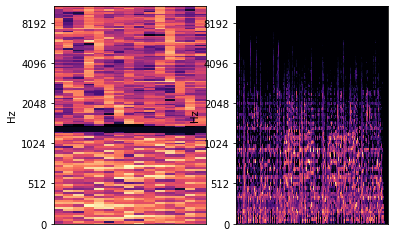

In [8]:
# Debug hole in mel spectrograms
test_volume = pre_process(data_paths[:2])
plt.subplot(1,2,1)
librosa.display.specshow(test_volume[10], hop_length=hop_length, sr=sr, y_axis='mel')
plt.subplot(1,2,2)
y, sr = librosa.load(data_paths[2], sr=None)
librosa.display.specshow(log_spectrogram(y), hop_length=hop_length, sr=sr, y_axis='mel')

## CNN model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

Using TensorFlow backend.


In [10]:
# create model
model = Sequential()

#add layers
model.add(Conv2D(32), kernel_size=3, activation='relu', input_shape=(24,1))

TypeError: __init__() missing 1 required positional argument: 'kernel_size'